In [1]:
import h5py
import brighteyes_flim
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu as otsu


In [5]:
#close previously opened .h5 files. If you don't have any .h5 file opened skip this cell

import gc
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            print(obj)
            obj.close()
        except:
            pass # Was already closed

<Closed HDF5 file>
<Closed HDF5 file>
<Closed HDF5 file>
<HDF5 file "06_Convallaria_LP51.h5" (mode r)>


In [ ]:
# Create an instance of the FlimData class to load the FLIM dataset related to the acquired image. 
# If you want to analyze an image acquired with the DFD architecture, two .h5 files' path need to be provided as inputs to the class:
# 1) The reference/calibration sample file path 
# 2) The investigated sample file path 

# The reference sample image is recorded and processed to calculate the IRF-associated phasor. This value is used to correct the IRF contribution in the phasor of the investigated sample

# If you want to analyze an image acquired with the TTM you just need to provide the file path containing the 4D image (x,y,t,ch) as input to the class.

# When creating and running the instance of the FlimData class, an .h5 file is created, storing the decay histograms in each pixel (for the DFD achitecture the histograms are realigned with respect to the signal which triggers the beginning of the excitation)

print(brighteyes_flim.__file__)
flim_ref=brighteyes_flim.FlimData(data_path_ttm = r"C:\Users\fdelbufalo\Desktop\images\Convallaria_LP_51",
                                  ignore_laser = True, 
                                 )                               #pre_filter=0.1

In [5]:
 # Use the method 'calculate_phasor_on_img_pixels' to get a H5 file storing the phasor in each pixel computed from the pixels' histogram contained in a .h5 file 
 # If you want to open the file containg the pixels' histograms acquired with the DFD architecture, you have to open the .h5 file "dataset_of_pixel_histogram_aligned" and use the key "h5_dataset" to access to the h5 dataset storing the histograms in each pixel
 # If you want to open the .h5 file containig the histograms' data of each pixel acquired with the BrightEyes TTM you have to ope the .h5 file "dataset_of_pixel_histogram_aligned_ttm" and use the key "h5_dataset_ttm" to access to the h5 dataset storing the histograms in each pixel 

with h5py.File('dataset_of_pixel_histogram_aligned_ttm',"a") as f:
    
        print(f.keys())
        data_input = f["h5_dataset_ttm"]  # image with the decay histograms in each pixel realigned with respect to the signal which triggers the beginning of the excitation

        fasors = brighteyes_flim.calculate_phasor_on_img_pixels(data_input) 

<KeysViewHDF5 ['h5_dataset_ttm']>


<KeysViewHDF5 ['h5_dataset']>
(2000, 2000)


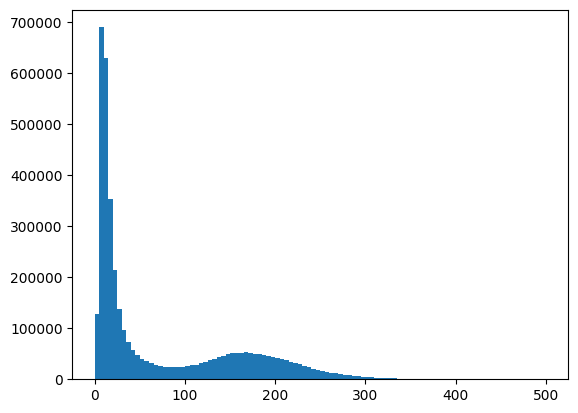

In [2]:
# Compute the 2D (x,y) image with histograms realigned in each pixel (photon counts in each pixel)
with h5py.File('dataset_of_pixel_histogram_aligned',"a") as f:
    
        print(f.keys())
        data_input = f["h5_dataset"]
        
        data_histograms = np.sum(data_input, axis = (2, 3))
        print(data_histograms.shape)
    
# Plot the histogram of the photon counts in each pixel to see the distribution (e.g. check the level of noise) 
        plt.figure()
        plt.hist(data_histograms.flatten(), bins = 100, range = (0, 500))

In [28]:
print(data_histograms.shape)


(2000, 2000)


In [3]:
# Process the histograms in each pixel to remove the pixels with a low amount of signal

# We want to process the histogram counts matrix and the tau matrix to check if the pixels with high counts have only tau positives 

from skimage.filters import threshold_otsu as otsu
histograms_filtered = otsu(image=data_histograms, nbins=50)
print(histograms_filtered)
hist_indexes = np.argwhere(data_histograms > histograms_filtered)
histogram_denoised = data_histograms[hist_indexes[:, 0], hist_indexes[:, 1]]
print(histogram_denoised)
print(hist_indexes.shape)

101.59377
[150.70987  167.03705  136.94987  ... 103.334206 114.03559  102.6633  ]
(1284528, 2)


<KeysViewHDF5 ['h5_dataset_phasor_pix']>
(2000, 2000)


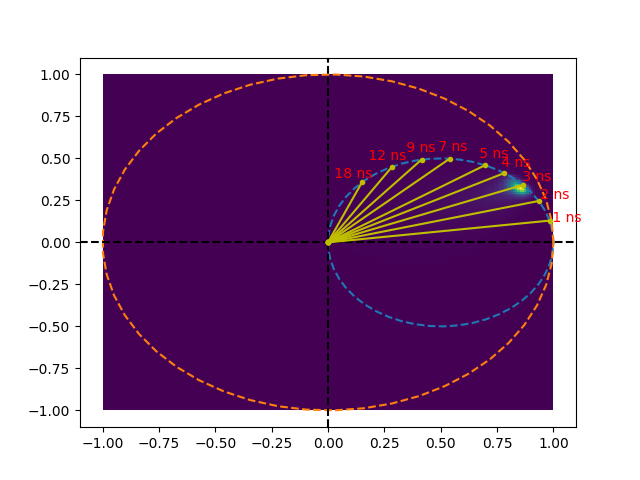

In [4]:
# Display the pixels'histogram-associated phasors in the phasor plot

%matplotlib widget

hf_phasors_per_pixel = h5py.File('dataset_of_phasor_per_pixel', "r")
print(hf_phasors_per_pixel.keys())

phasors_pix = hf_phasors_per_pixel["h5_dataset_phasor_pix"]  # data with phasors in each pixel
#fasors_pix[1:100, 1:100]
print(phasors_pix.shape)

brighteyes_flim.plot_phasor(phasors_pix[:], bins_2dplot=200, log_scale=False)

In [5]:
# Calculate the single pixels' tau (fluorescence lifetime) values from the phasors of each pixel 

tau_phi = brighteyes_flim.calculate_tau_phi(np.real(phasors_pix[:]), np.imag(phasors_pix[:]))
print(tau_phi.shape)
print(tau_phi)

#tau_flatten method

(2000, 2000)
[[ 3.73121217e-09  2.67735613e-09  2.79440534e-09 ... -1.89514442e-09
   7.48920371e-10  4.95947591e-09]
 [ 3.48659561e-09  3.43702490e-09  3.73473573e-09 ...  1.48743778e-09
   5.11448847e-09  2.77293841e-09]
 [ 2.54212695e-09  3.35229342e-09  3.29364382e-09 ... -2.48354935e-08
   2.67673858e-09  7.05871108e-10]
 ...
 [ 3.57794022e-09  3.21057841e-09  3.08907153e-09 ...  2.48618756e-08
  -3.66877264e-08 -5.88664409e-07]
 [ 3.20383402e-09  2.84709855e-09  3.62382698e-09 ... -2.59810514e-09
  -1.73617108e-08  8.04653587e-09]
 [ 3.35302674e-09  3.77216803e-09  2.94216300e-09 ...  8.65576400e-08
   1.89158672e-08  3.43121963e-09]]


[3.73121217e-09 2.67735613e-09 2.79440534e-09 ... 3.70348468e-09
 3.11854030e-09 2.99424499e-09]


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 4.00000e+00, 1.40000e+01, 8.80000e+01,
        2.69000e+02, 7.04000e+02, 1.78000e+03, 4.22200e+03, 1.08040e+04,
        2.64540e+04, 5.74430e+04, 1.04276e+05, 1.53330e+05, 1.81297e+05,
        1.77455e+05, 1.51606e+05, 1.19601e+05, 9.26050e+04, 7.10450e+04,
        5.23630e+04, 3.49500e+04, 2.12920e+04, 1.19400e+04, 6.05900e+03,
        2.66900e+03, 1.33600e+03, 5.45000e+02, 2.15000e+02, 9.20000e+01,
        4.90000e+01, 1.20000e+01, 7.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

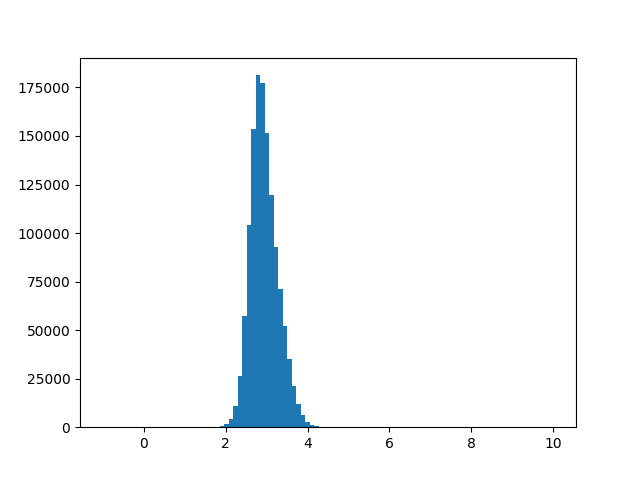

In [6]:
# Select the tau only from the pixels having a sufficient amount of photons, identified applying an image thresholding method (e.g., Otsu's method).

tau_phi_denoised = tau_phi[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_phi_denoised)
plt.figure()
plt.hist(1e9*tau_phi_denoised, bins = 100, range = (-1, 10))


(array([  4158.,   4454.,   4997.,   5435.,   5664.,   6168.,   6655.,
          7537.,   8186.,   9076.,  10402.,  11552.,  13387.,  14676.,
         17177.,  19245.,  23072.,  27107.,  31741.,  38202.,  46466.,
         57383.,  71702.,  90680., 120682., 181367., 416041., 757810.,
        597358., 348410., 180426., 106707.,  78676.,  62377.,  50559.,
         41892.,  35686.,  29838.,  26118.,  22502.,  19828.,  17071.,
         15386.,  13717.,  12478.,  11176.,  10194.,   9115.,   8179.,
          7835.]),
 array([-6.  , -5.68, -5.36, -5.04, -4.72, -4.4 , -4.08, -3.76, -3.44,
        -3.12, -2.8 , -2.48, -2.16, -1.84, -1.52, -1.2 , -0.88, -0.56,
        -0.24,  0.08,  0.4 ,  0.72,  1.04,  1.36,  1.68,  2.  ,  2.32,
         2.64,  2.96,  3.28,  3.6 ,  3.92,  4.24,  4.56,  4.88,  5.2 ,
         5.52,  5.84,  6.16,  6.48,  6.8 ,  7.12,  7.44,  7.76,  8.08,
         8.4 ,  8.72,  9.04,  9.36,  9.68, 10.  ]),
 <BarContainer object of 50 artists>)

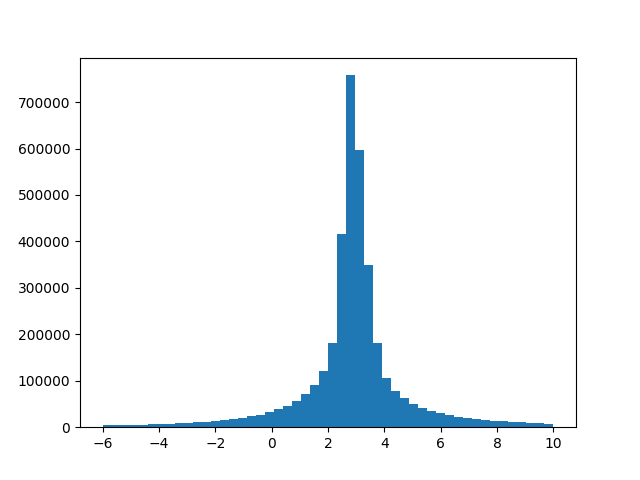

In [7]:
# Plot the distribution of tau values in all the pixels of the image 
tau_data = 1e9*tau_phi.flatten()

plt.figure()
plt.hist(tau_data, range = (-6, 10), bins = 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([[[ 0.        ,  0.14438725,  0.11853026],
         [ 0.19239287,  0.14309584,  0.        ],
         [ 0.10392972,  0.1012767 ,  0.        ],
         ...,
         [-0.21311331, -0.        , -0.26639163],
         [-0.20135238, -0.        , -0.25169048],
         [-0.20605676, -0.        , -0.25757095]],
 
        [[-0.        , -0.2105273 , -0.07132243],
         [ 0.        ,  0.08191637,  0.01974808],
         [ 0.        ,  0.15982564,  0.13231391],
         ...,
         [-0.21311331, -0.        , -0.26639163],
         [-0.22252202, -0.        , -0.27815253],
         [-0.26639163, -0.24832006, -0.        ]],
 
        [[-0.19386987, -0.09252095, -0.        ],
         [ 0.        ,  0.12270243,  0.00908861],
         [ 0.00790917,  0.19045369,  0.        ],
         ...,
         [-0.21546547, -0.        , -0.26933184],
         [-0.26051116, -0.19344302, -0.        ],
         [-0.22252202, -0.        , -0.27815253]],
 
        ...,
 
        [[-0.        , -0.12820092

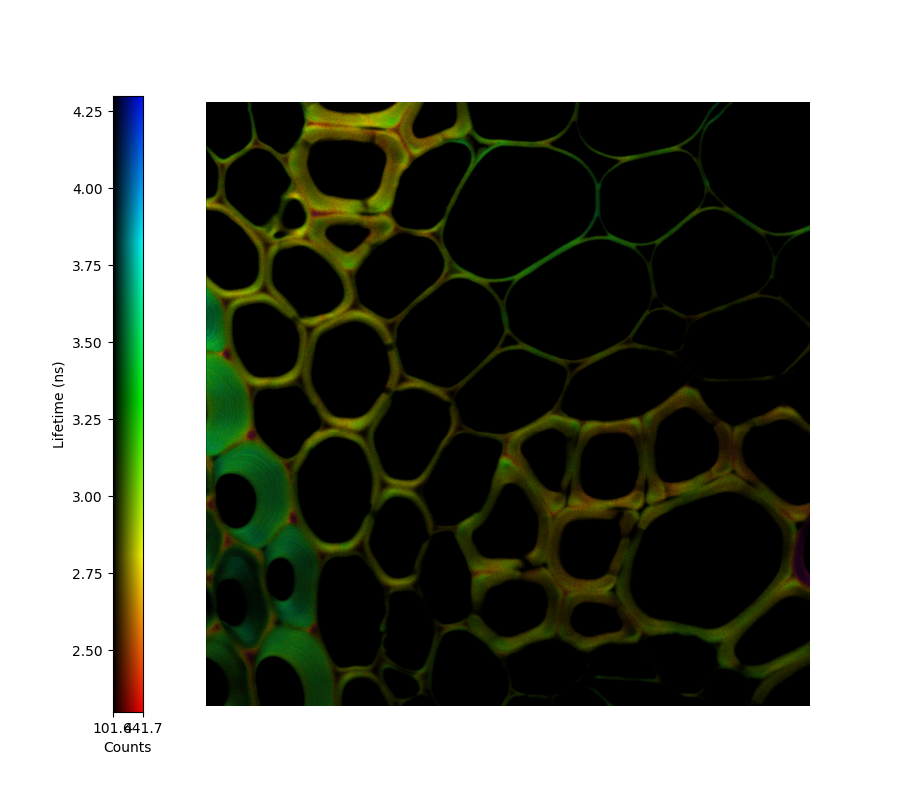

In [8]:
# Apply the method showFLIM contained in brighteyes_flim library to plot the FLIM image given the intensity array and the array storing the lifetime values in each pixel

# It is possible to manually select the extremes of the fluorescence lifetime values (minimum and max lifetimes present in the image).   
# If the bounds of tau are not specified, they are automatically calculated by showFLIM method applying an Otsu's method on the intensity image and selecting the lifetimes associated to the pixels having a minimum amount of photon counts as calculated by the Otsu's method

bounds_Tau = {
            "minTau": 2.3,
            "maxTau": 4.3,
        }


brighteyes_flim.showFLIM(data_histograms, tau_phi*1e9, bounds_tau = bounds_Tau)

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: >,
        <Axes: xlabel='Counts/240 $\\mathregular{\\mu s}$', ylabel='Lifetime (ns)'>],
       dtype=object))

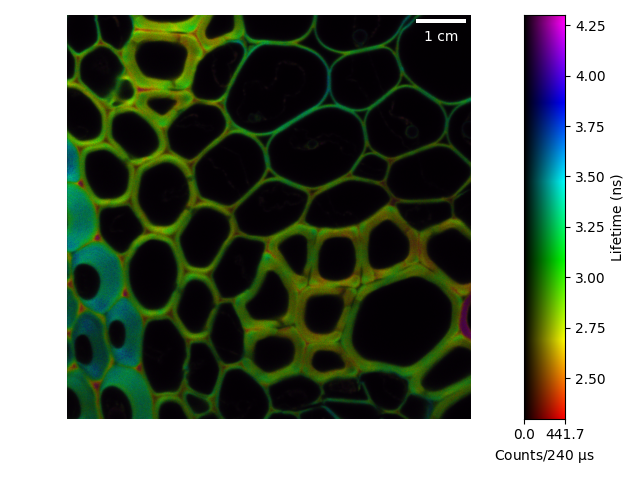

In [13]:
import brighteyes_ism.analysis.Graph_lib as gr

gr.show_flim(data_histograms, tau_phi*1e9, pxsize = 40, pxdwelltime = 240, lifetime_bounds = [2.3, 4.3])